In [1]:
import pandas as pd
import numpy as np
import statistics
import sklearn.metrics
import warnings
import random as rn
warnings.filterwarnings("ignore")

In [2]:
# set the seed for reproducibility
sd = 1234
np.random.seed(sd)
rn.seed(sd)
%env PYTHONHASHSEED=0


env: PYTHONHASHSEED=0


In [3]:
def get_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    num_correct_ann= annotation_df[annotation_df[correct_id_col]==annotation_df[predicted_id_col]].shape[0]
    acc=num_correct_ann/annotation_df.shape[0]
    return acc

In [4]:
def get_balanced_accuracy_verbose(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        print(cell_type)
        num_cells =cell_type_sub.shape[0]
        print("predicted cell ID")
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        print(perc)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    print("balanced accuracy:")
    print(balanced_accuracy)
    return balanced_accuracy

In [5]:
def get_balanced_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        num_cells =cell_type_sub.shape[0]
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    return balanced_accuracy

In [6]:
def get_cluster_accuracy(annotation_df, cluster_id_column ='clust',correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    correc_ann_counter=0
    annotation_df = annotation_df.groupby(cluster_id_column).filter(lambda x: len(x) > 10)
    cluster_ids =sorted(set(annotation_df[cluster_id_column]))
    for cluster_id in cluster_ids:
        cluster_sub = annotation_df[annotation_df[cluster_id_column]==cluster_id]   
        clust_real_id_counts = cluster_sub[correct_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_real_id = clust_real_id_counts.iloc[np.lexsort((clust_real_id_counts.index, -clust_real_id_counts.values))].index[0]
        clust_predicted_id_counts = cluster_sub[predicted_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_predicted_id = clust_predicted_id_counts.iloc[np.lexsort((clust_predicted_id_counts.index, -clust_predicted_id_counts.values))].index[0]
        if clust_real_id == clust_predicted_id:
            correc_ann_counter += 1
        else:
            continue
    clust_accuracy= correc_ann_counter/len(cluster_ids)
    return clust_accuracy

In [7]:
def get_cohens_kappa_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    cohens_kappa_score= sklearn.metrics.cohen_kappa_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(cohens_kappa_score)

In [8]:
def get_F1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest 
        # then convert df labels to binary classification tasks
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        #cell_type_sub = cell_type_sub[[correct_id_col, predicted_id_col]]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        F1_cell_type = sklearn.metrics.f1_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        F1_list.append(F1_cell_type)
    return(F1_list)

In [9]:
def get_macroF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID', label_list=None):
    if label_list ==None:
        label_list  = annotation_df[correct_id_col].value_counts().index   
    macroF1_score = sklearn.metrics.f1_score(annotation_df[correct_id_col], annotation_df[predicted_id_col],average='macro', labels=label_list)
    return(macroF1_score)


In [10]:
def get_medianF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_scores = get_F1_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianF1_score = statistics.median(F1_scores)
    return(medianF1_score)

In [11]:
def get_precision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        precision_cell_type = sklearn.metrics.precision_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        precision_list.append(precision_cell_type)
    return(precision_list)

In [12]:
def get_medianPrecision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_scores = get_precision_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(precision_scores)
    return(medianPrecision_score)

In [13]:
def get_recall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        recall_cell_type = sklearn.metrics.recall_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        recall_list.append(recall_cell_type)
    return(recall_list)

In [14]:
def get_medianRecall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_scores = get_recall_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(recall_scores)
    return(medianPrecision_score)

In [15]:
def get_adjusted_rand_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    adjusted_rand_score= sklearn.metrics.adjusted_rand_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(adjusted_rand_score)

In [16]:
def get_mathews_corr_coef_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    matthews_corrcoef_score= sklearn.metrics.matthews_corrcoef(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(matthews_corrcoef_score)

In [17]:
def get_common_cells(*dataframes):
    df_cell_list = [v.index for v in dataframes]
    common_cells= list(set.intersection(*map(set,df_cell_list)))
    return(common_cells)

In [18]:
def get_combined_annotations_df_for_common_cells(*frames, common_cells, cell_ID_column = "cell_IDs"):
    if not frames:
        return None
    if len(frames) == 1:
        return frames[0]
    out = frames[0]
    out = out.loc[common_cells,]
    for df in frames[1:]:
        out = out.merge(df.loc[common_cells,], on=cell_ID_column)
    return out

In [19]:

common_cells_across_methods = pd.read_csv("../../../../results/Fig1_Fig2_Fig3_SFig1-FACS_BM_scATAC/compare_annotation_performances/commonCells.csv", index_col=False)

In [20]:
common_cells_across_methods

,0
0,MPP_103
1,MPP_186
2,HSC_278
3,CMP_401
4,CMP_173
...,...
1866,CMP_593
1867,HSC_467
1868,MPP_132
1869,MEP_50


In [21]:
leiden_resolutions = ['0.1' ,'0.2' ,'0.3' ,'0.4' ,'0.5' ,'0.6' ,'0.7' ,'0.8' ,'0.9' ,'1.0' ,'1.1' ,'1.2' ,'1.3' ,'1.4' ,'1.5' ,'1.6' ,'1.7','1.8' ,'1.9' ,'2.0', '2.1', '2.2', '2.3', '2.4', '2.5']

In [22]:
# prepare results dataframe

scores_df = pd.DataFrame( index=['leiden_'+i for i in leiden_resolutions])

In [23]:
for res in leiden_resolutions:
    result_path = "../../../../results/Supplementary_tables/analysis_on_clustering_parameter/FACS_BM_scATAC_performance_acros_clustering_res/res"+ res + "/outputs/scATAcat_annotations_leiden_" + res +".csv"
    scATAcat_annotations = pd.read_csv(result_path, index_col=0)
    scATAcat_annotations.columns = ['leiden_'+res, 'scATAcat_annotation' ,'ground_truth_annotations']
    scATAcat_annotations['cell_IDs'] = scATAcat_annotations.index
    cluster_id_column ='leiden_'+res
    scATAcat_annotations.index.name = None
    # change HSC and MPP to HSC/MPP
    scATAcat_annotations = scATAcat_annotations.replace('HSC', 'HSC/MPP')
    scATAcat_annotations = scATAcat_annotations.replace('MPP', 'HSC/MPP')
    common_cells = list(common_cells_across_methods['0'])
    all_methods_for_commonCells= get_combined_annotations_df_for_common_cells(scATAcat_annotations, common_cells=common_cells, cell_ID_column = "cell_IDs")
    common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation))
    all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations.isin(common_annotations)]
    print(cluster_id_column)
    print(common_annotations)
    annotation_df = all_methods_for_commonCells_commonAnnotations
    correct_id_col = 'ground_truth_annotations'
    predicted_id_col = "scATAcat_annotation"
    scores_df.loc['leiden_'+ res, "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
    scores_df.loc['leiden_'+ res, "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, 'num_clust'] = scATAcat_annotations['leiden_'+ res].max()+1


leiden_0.1
['GMP', 'CLP', 'HSC/MPP', 'MEP']
leiden_0.2
['GMP', 'CLP', 'HSC/MPP', 'CMP', 'MEP']
leiden_0.3
['GMP', 'CLP', 'HSC/MPP', 'CMP', 'MEP']
leiden_0.4
['LMPP', 'GMP', 'CLP', 'HSC/MPP', 'CMP', 'MEP']
leiden_0.5
['LMPP', 'GMP', 'CLP', 'HSC/MPP', 'CMP', 'MEP']
leiden_0.6
['LMPP', 'GMP', 'CLP', 'HSC/MPP', 'CMP', 'MEP']
leiden_0.7
['LMPP', 'GMP', 'CLP', 'HSC/MPP', 'CMP', 'MEP']
leiden_0.8
['LMPP', 'GMP', 'CLP', 'HSC/MPP', 'CMP', 'MEP']
leiden_0.9
['LMPP', 'GMP', 'CLP', 'HSC/MPP', 'CMP', 'MEP']
leiden_1.0
['LMPP', 'GMP', 'CLP', 'HSC/MPP', 'CMP', 'MEP']
leiden_1.1
['LMPP', 'GMP', 'CLP', 'HSC/MPP', 'CMP', 'MEP']
leiden_1.2
['LMPP', 'GMP', 'CLP', 'HSC/MPP', 'CMP', 'MEP']
leiden_1.3
['LMPP', 'GMP', 'CLP', 'HSC/MPP', 'CMP', 'MEP']
leiden_1.4
['LMPP', 'GMP', 'CLP', 'HSC/MPP', 'CMP', 'MEP']
leiden_1.5
['LMPP', 'GMP', 'CLP', 'HSC/MPP', 'CMP', 'MEP']
leiden_1.6
['LMPP', 'GMP', 'CLP', 'HSC/MPP', 'CMP', 'MEP']
leiden_1.7
['LMPP', 'GMP', 'CLP', 'HSC/MPP', 'CMP', 'MEP']
leiden_1.8
['LMPP', 'GMP', '

In [24]:
scores_df

,accuracy,balanced_accuracy,cluster_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score,num_clust
leiden_0.1,0.967343,0.964174,1.000000,0.962798,0.962667,0.964046,0.977583,0.949797,0.915135,0.949562,4.0
leiden_0.2,0.883015,0.917771,1.000000,0.900551,0.892086,0.901961,0.924901,0.840771,0.689727,0.840270,5.0
leiden_0.3,0.884139,0.919129,1.000000,0.901010,0.892086,0.899306,0.924901,0.843224,0.693322,0.841987,5.0
leiden_0.4,0.868590,0.896498,1.000000,0.873139,0.867165,0.875582,0.889413,0.826911,0.683900,0.826354,7.0
leiden_0.5,0.864316,0.894347,1.000000,0.870220,0.861592,0.873629,0.886836,0.821422,0.673589,0.820799,8.0
leiden_0.6,0.865919,0.895206,1.000000,0.871042,0.864059,0.875769,0.889413,0.823575,0.677866,0.822928,8.0
leiden_0.7,0.866453,0.895465,1.000000,0.870731,0.865285,0.875875,0.889413,0.824307,0.679897,0.823661,8.0
leiden_0.8,0.865385,0.894948,1.000000,0.870408,0.863261,0.874947,0.889413,0.822864,0.676751,0.822228,9.0
leiden_0.9,0.817842,0.872594,0.900000,0.844104,0.831041,0.846028,0.909172,0.768235,0.566869,0.760324,10.0
leiden_1.0,0.817308,0.872335,0.900000,0.843811,0.830727,0.846028,0.909172,0.767624,0.565811,0.759627,10.0


In [25]:
scores_df.to_csv('../../../../results/Supplementary_tables/analysis_on_clustering_parameter/FACS_BM_scATAC_performance_acros_clustering_res/FACS_BM_scATAC_performance_acros_clustering_res.csv')

In [26]:
figures_dir = "../../../../results/Supplementary_tables/analysis_on_clustering_parameter/FACS_BM_scATAC_performance_acros_clustering_res/figures/"

In [27]:
import os
os.makedirs(figures_dir,exist_ok=True)

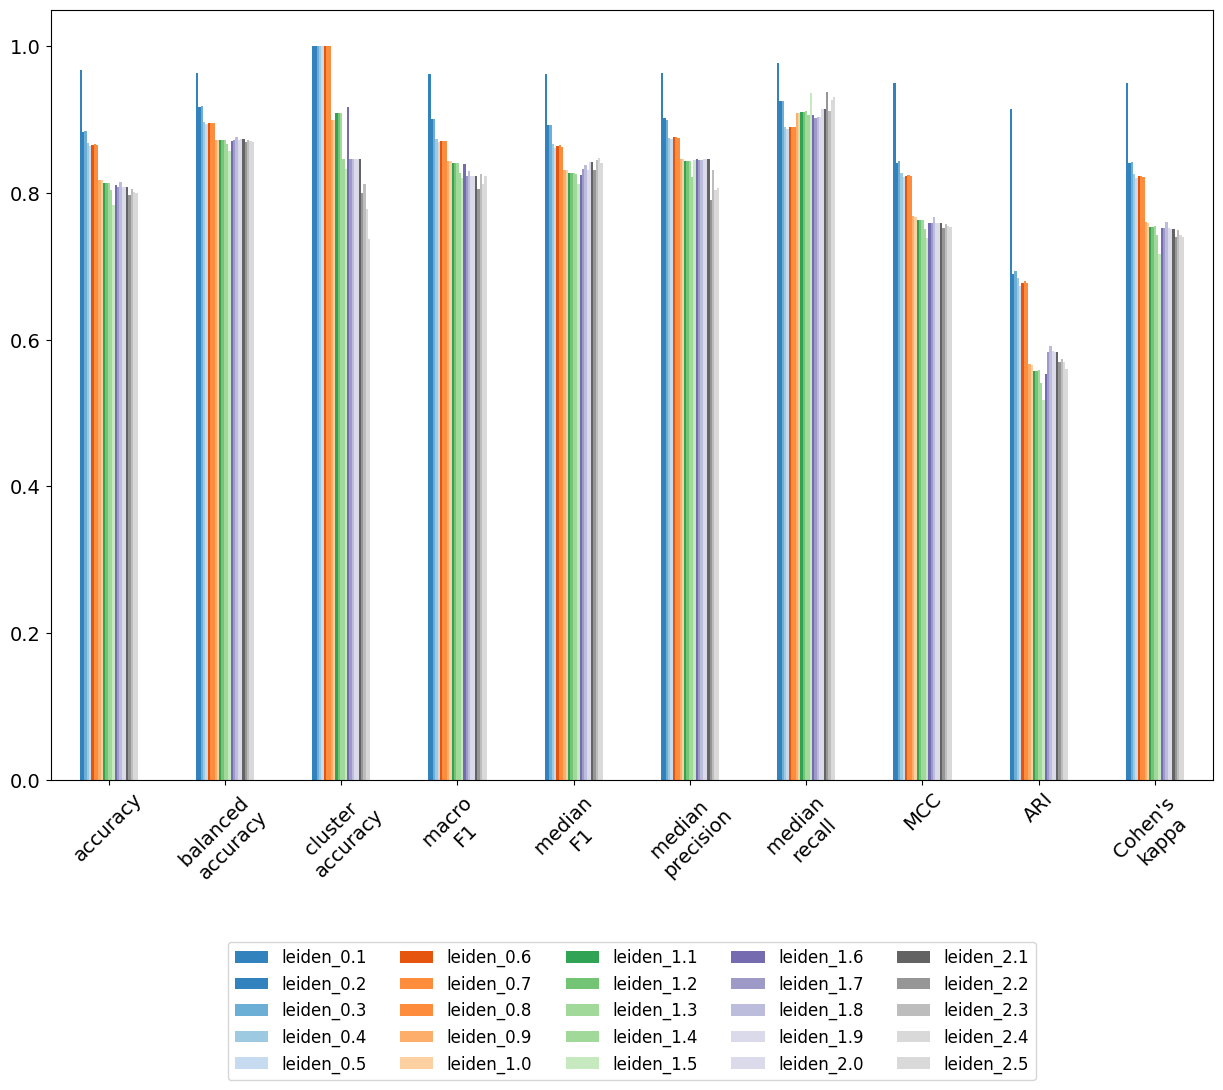

In [28]:
import matplotlib.pyplot as plt
scores_df = scores_df.iloc[:,:-1]
scores_df.columns = ['accuracy', 'balanced \naccuracy','cluster \naccuracy', 'macro \nF1', 'median \nF1',
                      'median \nprecision', 'median \nrecall','MCC', 'ARI', "Cohen's \nkappa"]

ax = scores_df.T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12,colormap='tab20c')
ax.set_ylim(ymin=0.0)
ax.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.2), ncol=5, fontsize=12)
#plt.title("evaluation scores for common cells and common annotations without EpiAnno", fontsize=15)
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.show()
plt.savefig(figures_dir + "FACS_BM_scATAC_performance_acros_clustering_res.png", bbox_inches='tight', transparent=True)
